In [1]:
import torch.nn as nn
import torch.nn.functional as F
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate') # padding mode same as original Caffe code
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [3]:
# learning parameters
batch_size = 64 # batch size, reduce if facing OOM error
epochs = 20 # number of epochs to train the SRCNN model for
lr = 0.001 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# input image dimensions
img_rows, img_cols = 33, 33
out_rows, out_cols = 33, 33

In [5]:
file = h5py.File('/kaggle/input/utility/train_mscale.h5')
# `in_train` has shape (21884, 33, 33, 1) which corresponds to
# 21884 image patches of 33 pixels height & width and 1 color channel
in_train = file['data'][:] # the training data
out_train = file['label'][:] # the training labels
file.close()
# change the values to float32
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

In [6]:
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Training samples:  16368
Validation samples:  5456


In [7]:
# the dataset module
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [8]:
# train and validation data
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [9]:
# initialize the model
print('Computation device: ', device)
model = SRCNN().to(device)
print(model)

Computation device:  cuda
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [10]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [11]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [12]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [13]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        save_image(outputs, f"../outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [15]:
import os
os.makedirs('../outputs')

In [16]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 20


256it [00:02, 125.32it/s]                         
86it [00:00, 301.60it/s]                        


Train PSNR: 26.828
Val PSNR: 27.275
Epoch 2 of 20


256it [00:01, 162.77it/s]                         
86it [00:00, 296.49it/s]                        


Train PSNR: 27.059
Val PSNR: 27.362
Epoch 3 of 20


256it [00:01, 163.26it/s]                         
86it [00:00, 300.72it/s]                        


Train PSNR: 27.128
Val PSNR: 27.368
Epoch 4 of 20


256it [00:01, 161.93it/s]                         
86it [00:00, 297.38it/s]                        


Train PSNR: 27.182
Val PSNR: 27.411
Epoch 5 of 20


256it [00:01, 161.52it/s]                         
86it [00:00, 291.23it/s]                        


Train PSNR: 27.194
Val PSNR: 27.486
Epoch 6 of 20


256it [00:01, 146.59it/s]                         
86it [00:00, 266.77it/s]                        


Train PSNR: 27.239
Val PSNR: 27.471
Epoch 7 of 20


256it [00:01, 152.20it/s]                         
86it [00:00, 284.45it/s]                        


Train PSNR: 27.241
Val PSNR: 27.500
Epoch 8 of 20


256it [00:01, 158.85it/s]                         
86it [00:00, 273.92it/s]                        


Train PSNR: 27.269
Val PSNR: 27.525
Epoch 9 of 20


256it [00:01, 160.02it/s]                         
86it [00:00, 292.08it/s]                        


Train PSNR: 27.281
Val PSNR: 27.530
Epoch 10 of 20


256it [00:01, 163.00it/s]                         
86it [00:00, 293.82it/s]                        


Train PSNR: 27.296
Val PSNR: 27.493
Epoch 11 of 20


256it [00:01, 160.88it/s]                         
86it [00:00, 280.49it/s]                        


Train PSNR: 27.316
Val PSNR: 27.590
Epoch 12 of 20


256it [00:01, 151.90it/s]                         
86it [00:00, 293.51it/s]                        


Train PSNR: 27.336
Val PSNR: 27.631
Epoch 13 of 20


256it [00:01, 161.77it/s]                         
86it [00:00, 291.50it/s]                        


Train PSNR: 27.355
Val PSNR: 27.658
Epoch 14 of 20


256it [00:01, 161.88it/s]                         
86it [00:00, 286.55it/s]                        


Train PSNR: 27.348
Val PSNR: 27.676
Epoch 15 of 20


256it [00:01, 161.18it/s]                         
86it [00:00, 289.59it/s]                        


Train PSNR: 27.379
Val PSNR: 27.691
Epoch 16 of 20


256it [00:01, 161.89it/s]                         
86it [00:00, 293.06it/s]                        


Train PSNR: 27.377
Val PSNR: 27.555
Epoch 17 of 20


256it [00:01, 147.43it/s]                         
86it [00:00, 234.33it/s]                        


Train PSNR: 27.408
Val PSNR: 27.713
Epoch 18 of 20


256it [00:01, 152.87it/s]                         
86it [00:00, 282.59it/s]                        


Train PSNR: 27.407
Val PSNR: 27.705
Epoch 19 of 20


256it [00:01, 153.03it/s]                         
86it [00:00, 262.38it/s]                        


Train PSNR: 27.431
Val PSNR: 27.731
Epoch 20 of 20


256it [00:01, 152.93it/s]                         
86it [00:00, 270.01it/s]                        

Train PSNR: 27.438
Val PSNR: 27.746
Finished training in: 0.656 minutes


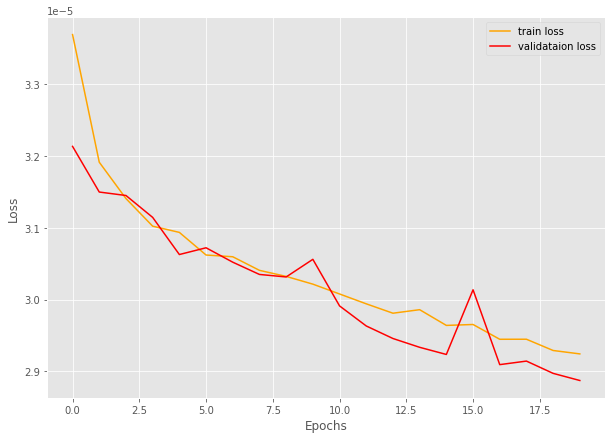

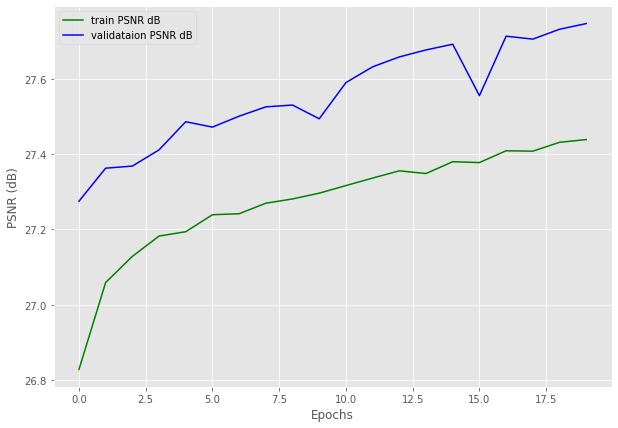

Saving model...


In [17]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.png')
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.savefig('../outputs/psnr.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '../outputs/model.pth')


In [18]:
x = torch.randn(1, 1, 37, 37, requires_grad=True).cuda()

torch.onnx.export(
                model,  # model being run
                x,  # model input
                '/kaggle/working/model.onnx',  # where to save the model
                #do_constant_folding=True,
                input_names=['input'],  # the model's input names (an arbitrary string)
                output_names=['output'],  # the model's output names (an arbitrary string)
                opset_version=9  # XGen supports 11 or 9
            )

In [32]:
from nni.algorithms.compression.pytorch.quantization import NaiveQuantizer
NaiveQuantizer(model).compress()

KeyError: 'nni.compression.pytorch'

In [28]:
#!pip install nni

from nni.compression.pytorch import ModelSpeedup
from nni.compression.pytorch.utils import count_flops_params
from nni.compression.pytorch.pruning import L1NormPruner, L2NormPruner

pre_flops, pre_params, _ = count_flops_params(model, torch.randn([1, 37, 37]).to(device))
g_epoch = 0

# Start to prune and speedup
print('\n' + '=' * 50 + ' START TO PRUNE THE BEST ACCURACY PRETRAINED MODEL ' + '=' * 50)
config_list = [{
    'sparsity': 0.5,
    'op_types': ['Conv2d']
}]

pruner = L2NormPruner(model, config_list)
_, masks = pruner.compress()
pruner.show_pruned_weights()
pruner._unwrap_model()
ModelSpeedup(model, dummy_input=torch.rand([1, 37, 37]).to(device), masks_file=masks).speedup_model()
print('\n' + '=' * 50 + ' EVALUATE THE MODEL AFTER SPEEDUP ' + '=' * 50)

SyntaxError: invalid syntax (jit_translate.py, line 541)

In [27]:
model.eval()

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)